In [1]:
%load_ext autoreload
%autoreload 2

In [37]:
import sys
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from nilearn import image
from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix, plot_stat_map
from nilearn.interfaces.fmriprep import load_confounds
from nilearn import plotting
sys.path.append('..')
from utils.data import Subject, load_participant_list

In [3]:
base_dir = '/Users/hugofluhr/data/LH_dev'
bids_dir = "/Users/hugofluhr/data/LH_dev/fmriprep-23.2.1"

dev_sub_ids = ['01', '02', '03', '05', '06', '09']
all_sub_ids = load_participant_list(base_dir)

sub_ids = all_sub_ids

In [4]:
subjects = [Subject(base_dir, sub_id, include_modeling=True, include_imaging=True, bids_dir=bids_dir) for sub_id in sub_ids]

/Users/hugofluhr/phd_local/repositories/RewardPairsTask_Analysis/notebooks/../utils/data.py:166: UserWarning: Last 1 trial(s) of block had no response, filling with 0
/Users/hugofluhr/phd_local/repositories/RewardPairsTask_Analysis/notebooks/../utils/data.py:166: UserWarning: Last 1 trial(s) of block had no response, filling with 0


# Setting parameters

In [5]:
tr = 2.33384

subject = subjects[10]
run = 'learning1'
# ref to the block
block = getattr(subject, run)

# Main model

In [6]:
events = block.extend_events_df()
events.head(5)

,onset,duration,trial_type,trial,first_stim_value_rl,first_stim_value_ck
0,0.012303,0.850695,first_stim_presentation,1,0.888207,0.0
1,0.862997,0.973241,second_stim_presentation,1,0.000000,0.0
2,1.836239,0.000000,response,1,0.000000,0.0
3,1.847222,1.551450,purple_frame,1,0.000000,0.0
4,2.364394,1.034278,points_feedback,1,0.000000,0.0


In [7]:
img_path = subject.img.get(run)
fmri_img = image.load_img(img_path)

In [8]:
confounds, sample_mask  = load_confounds(img_path,
                                         strategy=('motion','high_pass','wm_csf',
                                                   'scrub'),
                                         scrub=0,
                                         fd_threshold=0.5,
                                         std_dvars_threshold=1.5) # type: ignore

In [9]:
confounds.columns

Index(['cosine00', 'cosine01', 'cosine02', 'cosine03', 'cosine04', 'cosine05',
       'cosine06', 'cosine07', 'cosine08', 'cosine09', 'cosine10', 'cosine11',
       'cosine12', 'cosine13', 'csf', 'rot_x', 'rot_x_derivative1',
       'rot_x_derivative1_power2', 'rot_x_power2', 'rot_y',
       'rot_y_derivative1', 'rot_y_derivative1_power2', 'rot_y_power2',
       'rot_z', 'rot_z_derivative1', 'rot_z_derivative1_power2',
       'rot_z_power2', 'trans_x', 'trans_x_derivative1',
       'trans_x_derivative1_power2', 'trans_x_power2', 'trans_y',
       'trans_y_derivative1', 'trans_y_derivative1_power2', 'trans_y_power2',
       'trans_z', 'trans_z_derivative1', 'trans_z_derivative1_power2',
       'trans_z_power2', 'white_matter'],
      dtype='object')

# Using nilearn's FirstLevelModel

In [10]:
model1 = FirstLevelModel(
    t_r=2.33384,  # Set your TR (repetition time)
    slice_time_ref=.5,  # Set the slice timing reference
    noise_model='ar1',  # autocorrelation noise model
    standardize=True,  # standardize the data
    hrf_model='spm',
    drift_model=None,  # using the fmriprep high-pass filter
    high_pass=0.01,  # in Hz
    smoothing_fwhm=5,  # in mm
    mask_img=None,  # Specify a mask if needed, otherwise Nilearn can compute one
)

In [11]:
# Fit the model
model1 = model1.fit(fmri_img, events=events, confounds=confounds)#, sample_masks=sample_mask)

/Users/hugofluhr/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
response.
  warnings.warn(
/Users/hugofluhr/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: first_stim_value_rl, trial, first_stim_value_ck
  warnings.warn(


In [ ]:
#plot_design_matrix(model1.design_matrices_[0])
#plt.show()

# Explicitely building the design matrix

In [13]:
n = fmri_img.shape[-1]
frametimes = np.linspace(tr/2., (n - .5)*tr, n) # from Gilles, checked with nilearn FirstLevelModel

In [14]:
X1 = make_first_level_design_matrix(frame_times=frametimes,
                                    events=events,
                                    hrf_model='spm',
                                    drift_model=None,
                                    high_pass=0.01,
                                    add_regs=confounds)

/Users/hugofluhr/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
response.
  warnings.warn(
/Users/hugofluhr/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: first_stim_value_rl, trial, first_stim_value_ck
  warnings.warn(


In [18]:
# Compare the design matrics generated by both methods to confirm equivalence
(X1 - model1.design_matrices_[0]).sum().sum()

0.0

In [66]:
model2 = FirstLevelModel(smoothing_fwhm=5)

In [67]:
model2 = model2.fit(fmri_img, design_matrices=X1)

# Plotting results

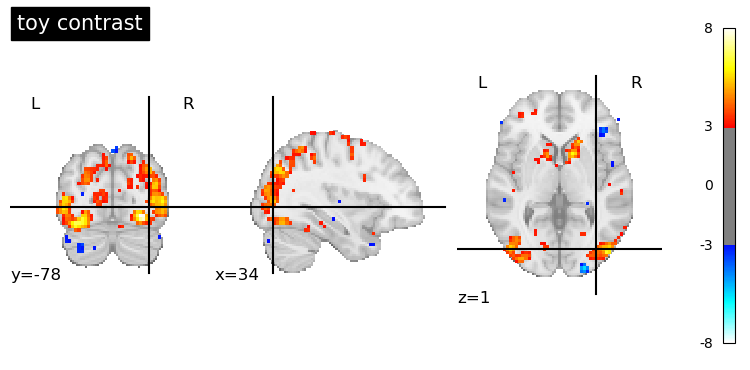

In [68]:
z_map1 = model1.compute_contrast(
    contrast_def="first_stim_presentation - iti", output_type="z_score"
)

plot_stat_map(
    z_map1,
    threshold=3.0,
    title=f"toy contrast",
)

In [69]:
z_map2 = model2.compute_contrast(
    contrast_def="first_stim_presentation - iti", output_type="z_score"
)
# Compate the 2 zmaps as additional check, changing any parameter (e.g. spatial smoothing changes the results)
(z_map1.dataobj-z_map2.dataobj).sum()


0.0